In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from plotting_utils import figure_path
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from repeats_utils import get_repeat_df, get_pymc_df, plot_pymc_bar
import pymc3 as pm
from scipy.stats import beta as sp_beta
from functools import partial, lru_cache
from scipy.stats import mode
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.viz_tools import color_encoder, okabeito_palette, simpsons_palette
from peak_utils import load_peaks, plot_repeats_RNA, ce, plot_repeat_peaks

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
plt.rc('font', **{'family':'sans-serif',
                 'sans-serif':'Arial'})
telo = 'TAACCC|CCCGAA|CCCCAA|CCCTAG|TTAGGC|TTAGGG'
telo += '|' + reverse_complement(telo)
centro = 'GAATG'
centro += '|' + reverse_complement(centro)
bf_label = ['Bayes factor>3', 'Not significant']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = get_pymc_df()
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,gene_name,gene_id,DNase: antisense,DNase: sense,NaOH: antisense,NaOH: sense,bayes_factor,delta,log_bf,col,is_telo
112,Simple_repeats:(CAT)n,Simple_repeats,189,197,3890,2523,1.000000e+12,0.116760,27.631021,Bayes factor>3,Tandem repeats
238,Simple_repeats:(GGGAGA)n,Simple_repeats,617,147,6364,543,1.000000e+12,0.115964,27.631021,Bayes factor>3,Tandem repeats
218,Simple_repeats:(GAATG)n,Simple_repeats,393,1628,13244,10669,1.000000e+12,0.358464,27.631021,Bayes factor>3,Centromere
220,Simple_repeats:(GAGAA)n,Simple_repeats,392,61,3375,232,1.000000e+12,0.074668,27.631021,Bayes factor>3,Tandem repeats
221,Simple_repeats:(GAGTG)n,Simple_repeats,365,2228,13323,11542,1.000000e+12,0.394174,27.631021,Bayes factor>3,Tandem repeats


In [8]:
df.query('bayes_factor > 3')

,gene_name,gene_id,DNase: antisense,DNase: sense,NaOH: antisense,NaOH: sense,bayes_factor,delta,log_bf,col,is_telo
112,Simple_repeats:(CAT)n,Simple_repeats,189,197,3890,2523,1.000000e+12,0.116760,27.631021,Bayes factor>3,Tandem repeats
238,Simple_repeats:(GGGAGA)n,Simple_repeats,617,147,6364,543,1.000000e+12,0.115964,27.631021,Bayes factor>3,Tandem repeats
218,Simple_repeats:(GAATG)n,Simple_repeats,393,1628,13244,10669,1.000000e+12,0.358464,27.631021,Bayes factor>3,Centromere
220,Simple_repeats:(GAGAA)n,Simple_repeats,392,61,3375,232,1.000000e+12,0.074668,27.631021,Bayes factor>3,Tandem repeats
221,Simple_repeats:(GAGTG)n,Simple_repeats,365,2228,13323,11542,1.000000e+12,0.394174,27.631021,Bayes factor>3,Tandem repeats
119,Simple_repeats:(CATCC)n,Simple_repeats,21,181,235,565,1.000000e+12,0.179095,27.631021,Bayes factor>3,Tandem repeats
229,Simple_repeats:(GGA)n,Simple_repeats,1100,819,7711,596,1.000000e+12,0.354984,27.631021,Bayes factor>3,Tandem repeats
230,Simple_repeats:(GGAA)n,Simple_repeats,1663,515,14991,3266,1.000000e+12,0.058190,27.631021,Bayes factor>3,Tandem repeats
273,Simple_repeats:(TCCG)n,Simple_repeats,4,178,90,180,1.000000e+12,0.299129,27.631021,Bayes factor>3,Tandem repeats
231,Simple_repeats:(GGAAA)n,Simple_repeats,478,64,3257,214,1.000000e+12,0.060011,27.631021,Bayes factor>3,Tandem repeats


In [5]:
@lru_cache(maxsize=32)
def sim_trace():
    base_df = df\
        .pipe(lambda d: d[(d['NaOH: antisense'] + d['NaOH: sense']) >= 50])\
        .assign(sense_fraction = lambda d: d['NaOH: sense']/(d['NaOH: antisense'] + d['NaOH: sense']))\

    
    with pm.Model() as model:
        a = pm.Exponential('a',1)
        b = pm.Exponential('b',1)
        beta = pm.Beta('beta', a, b, observed=base_df.sense_fraction)
        step = pm.NUTS()
        trace = pm.sample(1000, step = step, tune = 10000, cores = 24)
    return trace, base_df

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_log__, a_log__]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
NUTS: [b_log__, a_log__]
100%|██████████| 11000/11000 [00:16<00:00, 680.54it/s]
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/wor

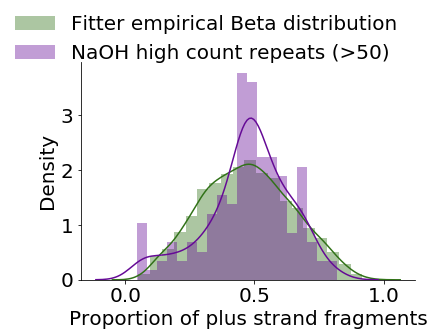

In [6]:
def plot_fit(ax):
    trace, base_df = sim_trace()
    rv = sp_beta(trace['a'].mean(), trace['b'].mean()).rvs(5000)
    sns.distplot(rv, 
             label = r'Fitter empirical Beta distribution', 
             ax = ax, bins=20,
             color = '#317218')
    sns.distplot(base_df.sense_fraction, 
                 label = 'NaOH high count repeats (>50)', 
                 ax=ax, bins=20,
                 color = '#650a96')
    ax.legend(fontsize=20, frameon=False,bbox_to_anchor = (1,1.3))
    ax.set_ylabel('Density')
    ax.set_xlabel('Proportion of plus strand fragments')
    
ax=plt.subplot(111)
plot_fit(ax)
sns.despine()
figurename = figure_path + '/pymc_beta.eps'
plt.savefig(figurename, bbox_inches='tight')

figurename = figure_path + '/pymc_beta.png'
plt.savefig(figurename, bbox_inches='tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


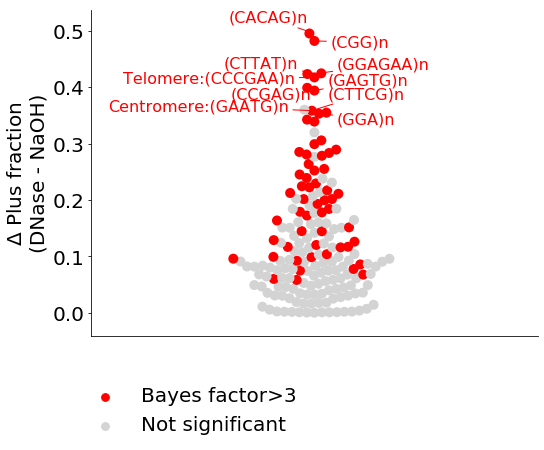

In [7]:
def plot_bf(df, ax):
    sns.swarmplot(y='delta', x='y', 
              data=df.assign(y = 1), 
              hue = 'col',
             hue_order = bf_label,
              size=10,
             palette= ['red','lightgray'],
            ax = ax)
    offsets = {'(CACAG)n': (-0.02, 0.02),
              '(CGG)n':(0.05,-0.01),
              '(CTTAT)n': (-0.05,0.01),
              '(GGAGAA)n':(0.07,0.01),
              'Telomere:(CCCGAA)n':(-0.06,-0.01),
              '(CCGAG)n':(-0.01,-0.02),
              '(GAGTG)n':(0.04, 0.01),
               '(CTTCG)n':(0.04,0.02),
              'Centromere:(GAATG)n':(-0.08,0),
              '(GGA)n':(0.07,-0.02)}
    for i, row in df.query('bayes_factor > 3')\
                .nlargest(10,'delta')\
                .reset_index(drop=True)\
                .iterrows():
        if row['is_telo'] =='Telomere':
            prefix = 'Telomere:' 
        elif row['is_telo'] == "Centromere":
            prefix = 'Centromere:'
        else:
            prefix = ''
        s = prefix + row['gene_name'].split(':')[1]
        ha = 'left' if offsets[s][0] > 0 else 'right'
        ax.annotate(s = s,
            fontsize=16,
            xy = (0, row['delta']),
            xytext = (offsets[s][0], row['delta'] + offsets[s][1]), 
            arrowprops = {'arrowstyle':'-', 
                          'color':'red'},
           ha = ha, color = 'red')
    ax.set_xlim(-0.7,0.7)
    ax.legend(title = '', fontsize=20, bbox_to_anchor=(0.5,-0.1), frameon=False)
    ax.xaxis.set_visible(False)
    ax.set_ylabel('$\Delta$ Plus fraction\n(DNase - NaOH)')
    
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plot_bf(df, ax)
sns.despine()
figurename = figure_path + '/pymc_delta.pdf'
plt.savefig(figurename, bbox_inches='tight')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


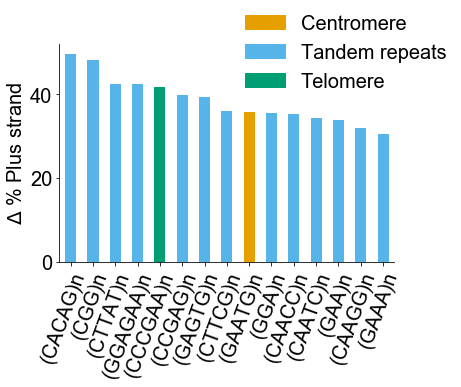

In [7]:
ax = plt.subplot() 
plot_pymc_bar(ax)
sns.despine()
figurename = figure_path + '/pymc_top_bar.png'
plt.savefig(figurename, bbox_inches='tight')

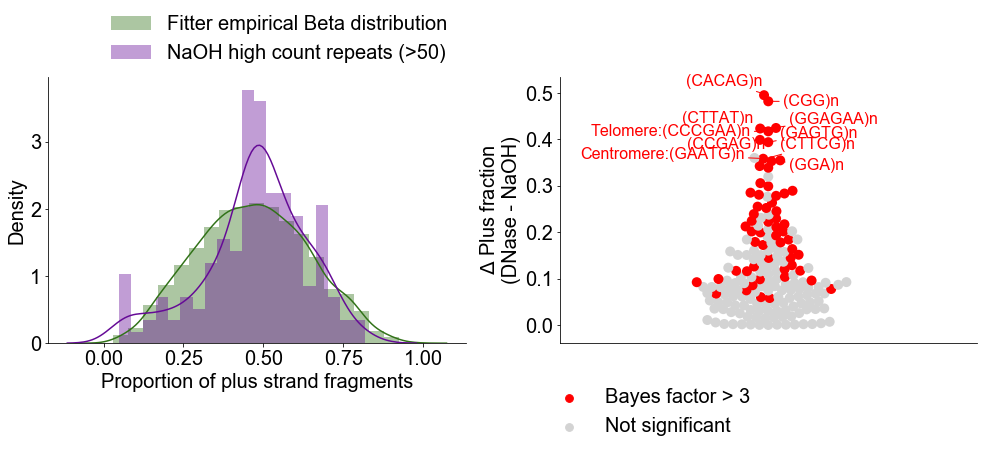

In [17]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(1,2,1)
#plot_repeat_peaks(ax)
#ax=fig.add_subplot(2,2,2)
plot_fit(ax)
ax = fig.add_subplot(1,2,2)
plot_bf(df,ax)
#ax = fig.add_subplot(2,2,4)
#plot_pymc_bar(ax)
sns.despine()
fig.tight_layout()
figurename = figure_path + '/pymc_figure.png'
plt.savefig(figurename, bbox_inches='tight')